# Complete Restart with JOGs using Orthofinder results
JOGs are Josiah's Orthogroups from Orthofinder run using latest assemblies

# HOG file parsing for gene names

In [1]:
from DNASkittleUtils.Contigs import read_contigs
from DNASkittleUtils.DDVUtils import pp
from os.path import join, basename, splitext
import os

In [2]:
def convert_to_gene_id(name):
    if name.startswith('FRAX'):  # not FRAEX for excelsior
        name = name[name.find('_')+1:]
        return name[:name.rfind('_')]  #chop off last _R0 tail
    if name.startswith('FRAEX'):
        name = name.replace('FRAEX38873_v2_', '')
        return name#[:name.rfind('.')]
    else:
        return name
assert convert_to_gene_id("FRAX19_000226960.2_R0") == "000226960.2", convert_to_gene_id("FRAX19_000226960.2_R0")
assert convert_to_gene_id("FRAEX38873_v2_000001220.2") == "000001220.2", convert_to_gene_id("FRAEX38873_v2_000001220.2")
tomato = 'Solyc03g095770.2.1 pacid=36135394 transcript=Solyc03g095770.2.1 locus=Solyc03g095770.2 ID=Solyc03g095770.2.1.ITAG2.4 annot-version=ITAG2.4 [Slycopersicum_390_ITAG2]'
assert convert_to_gene_id(tomato) == tomato


In [3]:
def parse_OGs_from_Orthogroups_csv():
    Orthogroups_csv = r"D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications\Ash_Proteome\Results_Jun25\Orthogroups.csv"
    HOGs = {}
    with open(Orthogroups_csv, 'r') as csv:
        for line in csv:
            genes = line.strip().split()
            og, genes = genes[0][:-1], genes[1:]  # split off first
            HOGs[og] = genes
    return HOGs

In [2]:
OGs = parse_OGs_from_Orthogroups_csv()
len(OGs)

64650

In [3]:
OGs['OG0047000']

['OE6A039394P1']

# Greedy merge algorithm
 ( agglomerative clustering? )
* Starting clusters can be HOGs
* clusters = dict{ gene: pointer to cluster }
* Clusters are set(gene)
* First gene gets a new cluster
* If gene A overlaps with gene B anywhere, then go through each cluster to find gene A and add gene B
* If gene B is in any other clusters, find it and merge the entire cluster into gene A cluster
* Assert a gene can only ever be in one cluster at a time, except in the atomic operation of merging two


### Starting from HOGs but no side-effects, using networkx to retreive clusters

[Python Network Graphs](https://www.python.org/doc/essays/graphs/)

[Creating a networkx graph](https://networkx.github.io/documentation/networkx-1.10/tutorial/tutorial.html)  
[Graph Connected Components](https://networkx.github.io/documentation/networkx-1.10/reference/generated/networkx.algorithms.components.connected.connected_components.html)

In [4]:
def map_genes_to_HOGs(HOGs):
    genes_to_HOGs = {}
    for hog, genes in HOGs.items():
        for gene in genes:
            if gene not in genes_to_HOGs:
                genes_to_HOGs[gene] = set()
            genes_to_HOGs[gene].add(hog)
    return genes_to_HOGs

def test_map_genes_to_HOGs():
    genes_to_HOGs_answer = {'gene1': {'HOG1'},
                     'gene2': {'HOG1', 'HOG2'},
                     'gene3': {'HOG2'}}
    HOGs = {'HOG1': set(('gene1', 'gene2')),
            'HOG2': set(('gene2', 'gene3'))}  # all HOGs start out parsed and non-exlusive
    genes_to_HOGs = map_genes_to_HOGs(HOGs)
    print(genes_to_HOGs, '\n',genes_to_HOGs_answer)
    assert genes_to_HOGs == genes_to_HOGs_answer
test_map_genes_to_HOGs()    

{'gene3': {'HOG2'}, 'gene1': {'HOG1'}, 'gene2': {'HOG2', 'HOG1'}} 
 {'gene3': {'HOG2'}, 'gene1': {'HOG1'}, 'gene2': {'HOG2', 'HOG1'}}


In [5]:
from itertools import combinations
import networkx

def create_cluster_network(genes_to_HOGs, HOGs, blacklist_genes=set(), blacklist_HOGs=set()):
    g = networkx.Graph()
    g.add_nodes_from(HOGs.keys())
    for gene, hogs in genes_to_HOGs.items():
        if len(hogs) > 1:
            if gene not in blacklist_genes:
                target_hogs = hogs.difference(blacklist_HOGs)
                # two HOGs have overlap and need to be merged
                g.add_edges_from(combinations(target_hogs, 2))  # add edge between all hogs
            
    return g

In [6]:
def make_super_HOGs(HOGs, networked_hogs):
    """collect subnetworks together into larger clusters"""
    super_HOGs = {}
    genes_seen = set()
    clusters = [c for c in sorted(networkx.connected_components(networked_hogs), key=len, reverse=True)]
    for cluster in clusters:
        name = '-'.join(cluster)
        super_HOGs[name] = set().union(gene for hog in cluster for gene in HOGs[hog])
        assert super_HOGs[name] not in genes_seen, "You missed a clustering connection.  Genes should only occur once"
        genes_seen.update(super_HOGs[name])
            
    return super_HOGs

def test_make_super_HOGs():
    super_HOGs_answer = {'HOG2-HOG1': {'gene1', 'gene2', 'gene3'}}
    HOGs = {'HOG1': set(('gene1', 'gene2')),
            'HOG2': set(('gene2', 'gene3'))}  # all HOGs start out parsed and non-exlusive
    genes_to_HOGs = map_genes_to_HOGs(HOGs)
    network = create_cluster_network(genes_to_HOGs, HOGs)
    assert str(network.edges()) == "[('HOG2', 'HOG1')]", network.edges()
    super_HOGs = make_super_HOGs(HOGs, network)
    print(super_HOGs)
    assert super_HOGs == super_HOGs_answer, super_HOGs
test_make_super_HOGs()

{'HOG2-HOG1': {'gene3', 'gene1', 'gene2'}}


### New way of clustering and tabulating using only orthogroups.csv

In [7]:
ogs_to_specific_genes = parse_OGs_from_Orthogroups_csv()
ogs_to_generic_genes = {og: set(convert_to_gene_id(g) for g in genes) for og, genes in ogs_to_specific_genes.items()}
generic_genes_to_ogs = map_genes_to_HOGs(ogs_to_generic_genes)

In [8]:
promiscuous_genes = [gene for gene, hogs in generic_genes_to_ogs.items() if len(hogs) > 20]
print(len(promiscuous_genes))
promiscuous_OGs = [hog for hog, genes in ogs_to_specific_genes.items() if len(genes) > 350]
len(promiscuous_OGs)

21


25

In [17]:
promiscuous_OGs

ogs_to_specific_genes['OG0000052']

['OG0000052',
 'OG0000058',
 'OG0000071',
 'OG0000013',
 'OG0000042',
 'OG0000066',
 'OG0000063',
 'OG0000007',
 'OG0000047',
 'OG0000070',
 'OG0000036',
 'OG0000065',
 'OG0000005',
 'OG0000009',
 'OG0000075',
 'OG0000014',
 'OG0000022',
 'OG0000051',
 'OG0000027',
 'OG0000015',
 'OG0000043',
 'OG0000060',
 'OG0000006',
 'OG0000050',
 'OG0000021',
 'OG0000038',
 'OG0000037',
 'OG0000002',
 'OG0000016',
 'OG0000069',
 'OG0000053',
 'OG0000010',
 'OG0000011',
 'OG0000018',
 'OG0000001',
 'OG0000057',
 'OG0000049',
 'OG0000028',
 'OG0000045',
 'OG0000029',
 'OG0000059',
 'OG0000041',
 'OG0000056',
 'OG0000003',
 'OG0000068',
 'OG0000019',
 'OG0000012',
 'OG0000023',
 'OG0000030',
 'OG0000033',
 'OG0000064',
 'OG0000055',
 'OG0000020',
 'OG0000039',
 'OG0000048',
 'OG0000017',
 'OG0000073',
 'OG0000040',
 'OG0000008',
 'OG0000054',
 'OG0000074',
 'OG0000032',
 'OG0000044',
 'OG0000035',
 'OG0000061',
 'OG0000024',
 'OG0000067',
 'OG0000004',
 'OG0000000',
 'OG0000034',
 'OG0000031',
 'OG00

In [9]:
network = create_cluster_network(generic_genes_to_ogs, ogs_to_generic_genes, promiscuous_genes, promiscuous_OGs)
JSG_to_specific_genes = make_super_HOGs(ogs_to_specific_genes, network)

In [10]:
pp(len(JSG_to_specific_genes))

'44,018'

In [11]:
all_species = 'FRAX00	FRAX01	FRAX02	FRAX03	FRAX04	FRAX05	FRAX06	FRAX07	FRAX08	FRAX09	FRAX11	FRAX12	FRAX13	FRAX14	FRAX15	FRAX16	FRAX19	FRAX20	FRAX21	FRAX23	FRAX25	FRAX26	FRAX27	FRAX28	FRAX29	FRAX30	FRAX31	FRAX32	FRAX33	FRAX34	Oeuropea	Mguttatus	Slycopersicum'.split('\t')
species_aliases = {'OE6': 'Oeuropea', 'Sol': 'Slycopersicum', 'Mig': 'Mguttatus'}
def extract_species(gene_name):
    if gene_name.startswith('FRAEX'):
        return 'FRAX00'
    elif gene_name.startswith('FRAX'):
        return gene_name.split('_')[0]
    else:
        three = gene_name[:3]
        return species_aliases[three]

In [12]:
from pandas import DataFrame    
def create_count_table_from_JSGs(JSG_to_specific_genes):
    """Map generic names back to their specifics and perform species count table based on those names"""
    table = []
    for jsg, specific_genes in JSG_to_specific_genes.items():
        species_row = {species: 0 for species in all_species}
        species_row['Desc'] = 'JSG' + str(len(table)).zfill(5)
        for gene in specific_genes:
            species_row[ extract_species(gene) ] += 1
        table.append(species_row)
        
    df = DataFrame(table, columns=['Desc'] + all_species) #table.loc[species_row['Family ID']] = species_row
    return df

table = create_count_table_from_JSGs(JSG_to_specific_genes)
print(len(table))
table.head()

44018


,Desc,FRAX00,FRAX01,FRAX02,FRAX03,FRAX04,FRAX05,FRAX06,FRAX07,FRAX08,...,FRAX28,FRAX29,FRAX30,FRAX31,FRAX32,FRAX33,FRAX34,Oeuropea,Mguttatus,Slycopersicum
0,JSG00000,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,JSG00001,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,JSG00002,2,1,6,3,2,3,2,2,4,...,3,4,3,2,4,3,3,3,1,2
3,JSG00003,1,3,2,1,1,0,2,1,1,...,1,1,1,1,1,1,0,2,1,1
4,JSG00004,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0


## Output new CSV counts

In [13]:
with open('Ash_Proteome/Results_Jun25/JSG_to_OG_mappings.csv', 'w') as out:
    line_count = 0
    for jsg, specific_genes in JSG_to_specific_genes.items(): 
        name = 'JSG' + str(line_count).zfill(5)
        line_count += 1
        out.write(name + "\t" + ','.join(jsg.split('-')) + '\t' + ','.join(specific_genes) + '\n' )

In [14]:
sums = table.sum(numeric_only=True, axis=1)
df = table.assign(sum= sums)
columns=['Desc', 'sum'] + all_species
df.index.name = 'Family ID'
df = df[columns]
df.sort_values('sum', ascending=False, inplace=True)
df.head()

,Desc,sum,FRAX00,FRAX01,FRAX02,FRAX03,FRAX04,FRAX05,FRAX06,FRAX07,...,FRAX28,FRAX29,FRAX30,FRAX31,FRAX32,FRAX33,FRAX34,Oeuropea,Mguttatus,Slycopersicum
Family ID,,,,,,,,,,,,,,,,,,,,,
14444,JSG14444,3349,110,108,109,105,90,105,95,108,...,110,109,105,69,110,110,84,209,74,75
28342,JSG28342,2797,22,106,84,93,79,114,100,102,...,93,107,94,84,98,105,85,23,0,0
40369,JSG40369,2551,79,78,89,77,74,82,75,82,...,79,85,75,78,81,90,67,102,54,48
32193,JSG32193,2294,76,67,69,67,66,68,72,71,...,68,74,66,59,66,69,61,109,89,75
2784,JSG02784,2156,49,64,65,59,54,73,72,79,...,75,71,76,54,66,65,52,200,43,15


In [15]:
df.to_csv('Ash_Proteome/Results_Jun25/JSG_GeneCounts.csv', sep='\t')

------

In [16]:
df[df['Desc'] == 'JSG22517']

,Desc,sum,FRAX00,FRAX01,FRAX02,FRAX03,FRAX04,FRAX05,FRAX06,FRAX07,...,FRAX28,FRAX29,FRAX30,FRAX31,FRAX32,FRAX33,FRAX34,Oeuropea,Mguttatus,Slycopersicum
Family ID,,,,,,,,,,,,,,,,,,,,,
22517,JSG22517,26,1,1,1,0,1,1,1,1,...,1,1,1,1,0,0,2,1,0,1


In [17]:
','.join(all_species)

'FRAX00,FRAX01,FRAX02,FRAX03,FRAX04,FRAX05,FRAX06,FRAX07,FRAX08,FRAX09,FRAX11,FRAX12,FRAX13,FRAX14,FRAX15,FRAX16,FRAX19,FRAX20,FRAX21,FRAX23,FRAX25,FRAX26,FRAX27,FRAX28,FRAX29,FRAX30,FRAX31,FRAX32,FRAX33,FRAX34,Oeuropea,Mguttatus,Slycopersicum'

In [ ]:
fraxinus_columns = df.loc[: ,'FRAX00':'FRAX34']
df['Fraxinus Std Dev'] = fraxinus_columns.std(axis=1)
df['Fraxinus Avg'] = fraxinus_columns.mean(axis=1)
df['Fraxinus Max'] = fraxinus_columns.max(axis=1)

In [99]:
df['Fraxinus Min'] = fraxinus_columns.min(axis=1)

In [75]:
len(df)

44018

In [103]:
criteria = (df['Fraxinus Avg'] > 1/15) & (df['Fraxinus Std Dev'] > 0)
criteria.sum()

14696

In [98]:
criteria = (df['Fraxinus Avg'] > 1/15) & (df['Fraxinus Std Dev'] > 0) & (df['Fraxinus Max'] <= 2 )
criteria.sum()

6653

In [102]:
criteria = (df['Fraxinus Avg'] > 1/15) & (df['Fraxinus Std Dev'] > 0) & (df['Fraxinus Max'] <= 2 ) & (df['Fraxinus Min'] == 1)
criteria.sum()

1319

Of 14,696 we lose about half 6,653 to large families.  That's a usable amount.  Eliminating 0's drops it to 1319, which probably isn't worth it.  Trinary states isn't so bad.

In [ ]:
for jsg in df[criteria]['Desc']:
    # we immediately run into an inability to map back to OGs
    # I need to determine JSG names and save the mapping explicitly in make_super_HOGs()

# Everything that follows is Old method using GeneCount.csv file

_________

### Actual Clusters with Real HOGs

In [12]:
actual_genes_to_OGs = map_genes_to_HOGs(OGs)
actual_network = create_cluster_network(actual_genes_to_OGs, OGs)
super_OGs = make_super_HOGs(OGs, actual_network)

"{:,}".format(len(OGs) - len(super_OGs)) + "  Reduced count"

'13,306  Reduced count'

## Compose new alignment with Super HOGs

In [13]:
from DNASkittleUtils.DDVUtils import pp
modified_HOGs_only = [c for c in sorted(networkx.connected_components(actual_network), key=len, reverse=True) if len(c) > 1]
pp(len(modified_HOGs_only))

'5,347'

In [15]:
assert all(['-'.join(h) in super_OGs for h in modified_HOGs_only])

### Blacklist promiscuous genes and HOGs

In [ ]:
actual_genes_to_OGs = map_genes_to_HOGs(OGs)
len(actual_genes_to_OGs)

In [ ]:
promiscuous_genes = [gene for gene, hogs in actual_genes_to_OGs.items() if len(hogs) > 5]
len(promiscuous_genes)

promiscuous_OGs = [hog for hog, genes in OGs.items() if len(genes) > 150]
len(promiscuous_OGs)

In [21]:
actual_network = create_cluster_network(actual_genes_to_OGs, OGs, promiscuous_genes, promiscuous_OGs)
super_HOGs = make_super_HOGs(OGs, actual_network)

print("{:,}".format(len(OGs) - len(super_HOGs)) + "  Reduced count")
smart_modified_HOGs = [c for c in sorted(networkx.connected_components(actual_network), key=len, reverse=True) if len(c) > 1]
pp(len(smart_modified_HOGs)), "HOGs"

11,713  Reduced count


In [26]:
len(super_HOGs)

52937

# Cluster rows by new super groups and output GeneCount.csv for new CAFE run

In [38]:
smart_modified_HOGs[:10]  # going to be used for grouping rows together

[{'OG0000848',
  'OG0001316',
  'OG0001331',
  'OG0001620',
  'OG0001679',
  'OG0002719',
  'OG0003830',
  'OG0005353',
  'OG0007285',
  'OG0007534',
  'OG0008375',
  'OG0009430',
  'OG0010137',
  'OG0010197',
  'OG0010551',
  'OG0011854',
  'OG0012187',
  'OG0012608',
  'OG0014503',
  'OG0018028',
  'OG0019062',
  'OG0019438',
  'OG0020872',
  'OG0023528',
  'OG0023682',
  'OG0025173',
  'OG0031433',
  'OG0031546',
  'OG0036452'},
 {'OG0000845',
  'OG0002526',
  'OG0002707',
  'OG0002935',
  'OG0006075',
  'OG0008106',
  'OG0008524',
  'OG0009022',
  'OG0016155',
  'OG0019891',
  'OG0020765',
  'OG0022144',
  'OG0024521',
  'OG0025822',
  'OG0026320',
  'OG0027131',
  'OG0027770',
  'OG0030545',
  'OG0030884',
  'OG0031134',
  'OG0032084',
  'OG0032507',
  'OG0032861',
  'OG0032996',
  'OG0033679',
  'OG0035244',
  'OG0035659',
  'OG0037245',
  'OG0038070'},
 {'OG0017549',
  'OG0019437',
  'OG0019487',
  'OG0019883',
  'OG0020636',
  'OG0020785',
  'OG0024164',
  'OG0030401',
  'OG003

In [39]:
from pandas import read_csv
counts = read_csv(r"D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications\Ash_Proteome\Results_Jun25\Cafe_orthofinder_Orthogroups.GeneCount.csv", sep='\t')
counts.head()

,Desc,Family ID,FRAX00,FRAX01,FRAX02,FRAX03,FRAX04,FRAX05,FRAX06,FRAX07,...,FRAX28,FRAX29,FRAX30,FRAX31,FRAX32,FRAX33,FRAX34,Mguttatus,Oeuropea,Slycopersicum
0,OG0000000,0,11,22,29,17,35,23,28,23,...,27,27,22,28,24,23,20,1,19,5
1,OG0000001,1,22,20,15,19,20,16,20,17,...,16,16,20,20,18,20,20,9,20,10
2,OG0000002,2,19,15,12,15,16,17,18,17,...,17,15,17,15,13,18,18,9,22,13
3,OG0000003,3,24,10,6,12,15,13,15,17,...,13,19,12,15,14,13,12,21,34,24
4,OG0000004,4,20,16,11,10,13,15,16,15,...,13,14,15,15,14,15,15,8,13,12


In [118]:
len(counts)

33693

For each group of OGs:
- sum their rows
- add a new row called JSG0028362+
- delete previously used rows

In [126]:
new_table = counts.copy()

In [127]:
for i, group in enumerate(smart_modified_HOGs):
    selected_rows = counts['Desc'].isin(group)
    if len(group) != selected_rows.sum():
        print(len(group), selected_rows.sum(), end='; ')
    new_row = counts[selected_rows].sum(numeric_only=True)
    badge_n = i + OG0064650
    badge = 'JSG' + str(badge_n).zfill(7)
    new_row['Desc'] = badge
    new_row['Family ID'] = badge_n
    new_table.loc[badge] = new_row
    

29 26; 29 17; 23 7; 22 17; 21 9; 21 19; 20 12; 19 9; 19 16; 17 9; 17 10; 17 9; 17 4; 17 13; 17 10; 17 5; 17 9; 16 5; 16 9; 16 11; 16 12; 15 13; 15 13; 15 9; 15 5; 15 6; 15 6; 14 10; 14 7; 14 10; 14 7; 14 12; 14 5; 14 11; 14 10; 14 11; 14 13; 13 8; 13 5; 13 12; 13 7; 13 11; 13 9; 13 8; 13 3; 13 3; 13 9; 13 8; 13 7; 13 4; 13 9; 13 6; 13 11; 13 7; 13 3; 13 9; 13 6; 12 10; 12 6; 12 9; 12 6; 12 8; 12 9; 12 1; 12 7; 12 7; 12 11; 12 11; 12 8; 12 10; 12 8; 12 10; 12 7; 12 7; 11 9; 11 6; 11 7; 11 5; 11 5; 11 7; 11 7; 11 8; 11 7; 11 10; 11 10; 11 9; 11 3; 11 2; 11 6; 11 5; 11 9; 11 10; 11 1; 10 4; 10 9; 10 2; 10 9; 10 4; 10 6; 10 9; 10 3; 10 5; 10 6; 10 3; 10 7; 10 9; 10 6; 10 9; 10 2; 10 5; 10 6; 10 6; 10 6; 10 5; 10 6; 10 3; 10 2; 10 5; 10 9; 10 6; 10 9; 9 8; 9 7; 9 7; 9 4; 9 4; 9 8; 9 3; 9 4; 9 8; 9 5; 9 8; 9 6; 9 7; 9 8; 9 6; 9 6; 9 5; 9 4; 9 8; 9 6; 9 6; 9 7; 9 5; 9 3; 9 7; 9 7; 9 6; 9 7; 9 6; 9 5; 9 6; 9 2; 9 7; 9 5; 9 4; 9 3; 9 4; 9 6; 9 5; 9 5; 9 4; 9 3; 9 4; 9 5; 9 4; 9 3; 9 3; 9 7; 9 8

In [128]:
from itertools import chain
rows_mentioned = set(chain(*smart_modified_HOGs))
print(len(rows_mentioned))

17044


In [129]:
list(rows_mentioned)[:10]

['OG0018821',
 'OG0022545',
 'OG0026509',
 'OG0036072',
 'OG0026401',
 'OG0017896',
 'OG0009334',
 'OG0006179',
 'OG0029711',
 'OG0031620']

How could there possibly be numbers mentioned here that are not in the table?  Can I use a mask instead?

In [130]:
old_rows_removed = new_table[~new_table['Desc'].isin(rows_mentioned)]
print(len(old_rows_removed))
old_rows_removed.head()

21603


,Desc,Family ID,FRAX00,FRAX01,FRAX02,FRAX03,FRAX04,FRAX05,FRAX06,FRAX07,...,FRAX28,FRAX29,FRAX30,FRAX31,FRAX32,FRAX33,FRAX34,Mguttatus,Oeuropea,Slycopersicum
0,OG0000000,0,11,22,29,17,35,23,28,23,...,27,27,22,28,24,23,20,1,19,5
1,OG0000001,1,22,20,15,19,20,16,20,17,...,16,16,20,20,18,20,20,9,20,10
2,OG0000002,2,19,15,12,15,16,17,18,17,...,17,15,17,15,13,18,18,9,22,13
3,OG0000003,3,24,10,6,12,15,13,15,17,...,13,19,12,15,14,13,12,21,34,24
4,OG0000004,4,20,16,11,10,13,15,16,15,...,13,14,15,15,14,15,15,8,13,12


In [131]:
type(new_table.loc[0]['Family ID']) #counts['Desc'] == 'OG0000000'][0]#.type

numpy.int64

In [132]:
print(len(new_table))
new_table.tail()

33693


,Desc,Family ID,FRAX00,FRAX01,FRAX02,FRAX03,FRAX04,FRAX05,FRAX06,FRAX07,...,FRAX28,FRAX29,FRAX30,FRAX31,FRAX32,FRAX33,FRAX34,Mguttatus,Oeuropea,Slycopersicum
JSG0033688,JSG0033688,33688,3,3,3,3,3,3,2,3,...,3,3,3,2,3,2,3,2,3,3
JSG0033689,JSG0033689,33689,2,2,1,2,2,2,2,1,...,2,0,0,2,2,2,2,1,2,1
JSG0033690,JSG0033690,33690,2,1,2,1,1,1,1,1,...,0,1,1,1,1,1,1,1,1,1
JSG0033691,JSG0033691,33691,2,2,0,1,1,2,2,1,...,1,1,2,2,1,1,1,1,2,1
JSG0033692,JSG0033692,33692,1,0,1,0,0,0,0,0,...,1,2,2,0,1,1,0,0,0,0


Up until now we haven't ran a clade filter because combining rows might join some things and make it pass the filter.  Now we need to filter out our rows so that we have usable families for CAFE.  There should be at least one copy in an Oleaceae species.

## New Plan: only use OrthoGroups.csv
Cafe_orthofinder_Orthogroups.GeneCount.csv is filtered to have at least two genes in any family.  We don't want this filter apriori, only after clustering.  

- Important: super HOGs network need to be redone with this as its new source.
- Important: start pulling of the _R1 tail, that's not helpful.

------------------

# Old code using FASTA sequence files for HOG definitions, useful for MSA viz output

In [ ]:
def parse_HOGs_from_fasta_directory():
    directory_HOGs = r"D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications\Ash_Proteome\Results_Jun25\Orthologues_Jul06\Sequences"
    from glob import glob
    from os.path import join, splitext, basename
    file_list = glob(join(directory_HOGs, "*.fa"))
    HOGs = {}
    for i, filename in enumerate(file_list):
        if i % 1000 == 0:
            print(basename(filename))
        assert basename(filename).startswith('OG')
        headers = []
        with open(filename, 'r') as fasta:
            for line in fasta:
                if line.startswith('>'):
                    headers.append(convert_to_gene_id(line[1:-1]))
        #assert len(headers) == len(set(headers)), "There was a redundant gene mention %s" % headers 
        HOGs[basename(splitext(filename)[0])] = headers
    return HOGs
HOGs = parse_HOGs_from_fasta_directory()
len(HOGs)

_We could simply exclude all modified HOGs from the data as being ambiguous_

### Concat super HOG fasta files into a new directoy

In [ ]:
from os.path import join, basename, splitext
import os
family_out_dir = r"D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications\Ash_Proteome\Results_Jun25\Orthologues_Jul06\super_JOGs__tail"
HOGfasta = r"D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications\Ash_Proteome\Results_Jun25\Orthologues_Jul06\Sequences"
os.makedirs(family_out_dir)
for family in modified_HOGs_only:
    family_name = ('-'.join(family))[:200] + '.fa'
    with open(join(family_out_dir, family_name), 'wb') as concat:  # output file concatenation
        for hog in family:
            with open(join(HOGfasta, hog + '.fa'), 'rb') as hog_file:  # smaller input file
                concat.write(hog_file.read())  # dump the whole file
#                 concat.write('\n')  # just to be safe
            

### Align the new gene family files

In [ ]:
import subprocess
import multiprocessing
from datetime import datetime
import os
from os.path import dirname, join, basename
from Bio.Align.Applications import MuscleCommandline
from DNASkittleUtils.CommandLineUtils import just_the_name
from glob import glob

def do_alignment(args):
#     print("starting alignment")
    index, fa, output_folder = args
    target = join(output_folder, just_the_name(fa) + '.fa')
    muscle_exe = 'muscle3.8.31_i86win32.exe'

    if not os.path.exists(target):
        muscle_cline = MuscleCommandline(muscle_exe, input=fa, out=target)
        try:
            stdout, stderr = muscle_cline()
        except subprocess.CalledProcessError as err:
            print(err.stderr)
        print(datetime.now(), just_the_name(fa), '{:%}'.format(index / 5347))

def batch_align_sequences(input_folder, output_folder):
    start = datetime.now()
    input_folder = os.path.abspath(input_folder)
    os.makedirs(output_folder, exist_ok=True)
    files = glob(os.path.join(input_folder, '*.fa'))
    files = sorted(files, key= os.path.getsize)
    args = [(i, ipath, output_folder) for i, ipath in list(enumerate(files))]
    for line in args:
        do_alignment(line)
#     pool.map(do_alignment, args)
        
    return os.path.abspath(output_folder)

#You can't actually do multiprocessing from a notebook
# if __name__ == '__main__':  # https://github.com/jupyter/notebook/issues/2080
#     pool = multiprocessing.Pool(10)


In [ ]:
family_aligned_dir = r"D:\Genomes\Ash_Gene_Families\test\aligned"   
family_fasta_dir = r"D:\Genomes\Ash_Gene_Families\test"

batch_align_sequences(input_folder = family_fasta_dir,
                      output_folder = family_aligned_dir)

In [ ]:
family_aligned_dir = r"D:\Genomes\Ash_Gene_Families\aligned"   
family_fasta_dir = r"D:\Genomes\Ash_Gene_Families"

batch_align_sequences(input_folder = family_fasta_dir,
                      output_folder = family_aligned_dir)

In [ ]:
family_aligned_dir = r"D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications\data\super_hog_test_viz\aligned"   
family_fasta_dir = r"D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications\data\super_hog_test_viz"

batch_align_sequences(input_folder = family_fasta_dir,
                      output_folder = family_aligned_dir)

In [ ]:
family_aligned_dir = r"D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications\data\phylogenetic_guides\aligned"   
family_fasta_dir = r"D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications\data\phylogenetic_guides"

batch_align_sequences(input_folder = family_fasta_dir,
                      output_folder = family_aligned_dir)

In [ ]:
do_alignment((1, r"D:\Genomes\Ash_Gene_Families\OG0037028-OG0004348.fa",
             r"D:\Genomes\Ash_Gene_Families\test\aligned"))

In [ ]:
do_alignment((1, r"D:\Genomes\Ash_Gene_Families\test\FRAX04_pair.fa", r'D:\Genomes\Ash_Gene_Families\test\aligned'))

In [ ]:

list(enumerate(glob(join(r'D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications\data\candidates', '*.fa'))))

* output files with lists of gene names to look for in each HOG
* per species, find those gene names in the annotation
* count presence / absence of a gene name in an annotation
* group them back by super-HOGs
* End result: gene copy count per each gene family defined by a super-HOG

_Should I call this a multigene family?_

# Fasta Processing

In [ ]:
from DNASkittleUtils.Contigs import read_contigs
seqs = read_contigs(r"D:\Genomes\Ash_Gene_Families\OG0014503-OG0018028-OG0009430-OG0001620-OG0012608-OG0012187-OG0003830-OG0005353-OG0000848-OG0001316-OG0001679-OG00.fa")
print(len(seqs))
%matplotlib inline
import pandas
lengths = [len(contig.seq) for contig in seqs ]
df = pandas.Series(lengths)#, columns=['Family ID', 'Copies'])
bins = 20
f = df.hist(bins=bins, figsize=(10,5), )#dpi=300)
f.grid(False)
# f.set_xticks(range(bins))
f.set_title("Are sequences clustered together actually the same size?")
f.set_xlabel("Sequence Length")
f.set_ylabel("Number of Sequences")

**Conclusion: This indicates that the file I opened is a massive super cluster with over 1,000 sequences in the 500 range and many more besides.  Making a cluster this big is not helpful to my analysis.**

In [ ]:
for family in modified_HOGs_only:
    if 'OG0018028' in family:
        print(family)

In [ ]:
len({'OG0023682', 'OG0001620', 'OG0008375', 'OG0036452', 'OG0019438', 'OG0000848', 'OG0025173', 'OG0007534', 'OG0001316', 'OG0019062', 'OG0002719', 'OG0012608', 'OG0003830', 'OG0010137', 'OG0023528', 'OG0007285', 'OG0014503', 'OG0011854', 'OG0010197', 'OG0020872', 'OG0001331', 'OG0009430', 'OG0018028', 'OG0010551', 'OG0031433', 'OG0031546', 'OG0001679', 'OG0012187', 'OG0005353'})

In [ ]:
def i_hist(values):
    bins = [0] * (max(values) +1)
    for v in values:
        bins[v] += 1
    return bins
i_hist([len(family) for family in modified_HOGs_only])  # cap at 10

In [ ]:
list(zip(range(400), i_hist([len(genes) for genes in HOGs.values()]) ))  # cap at 200

In [ ]:
i_hist([len(ogs) for ogs in actual_genes_to_HOGs.values()])  # cap at 6 HOGs per gene

### Blacklist promiscuous genes and HOGs

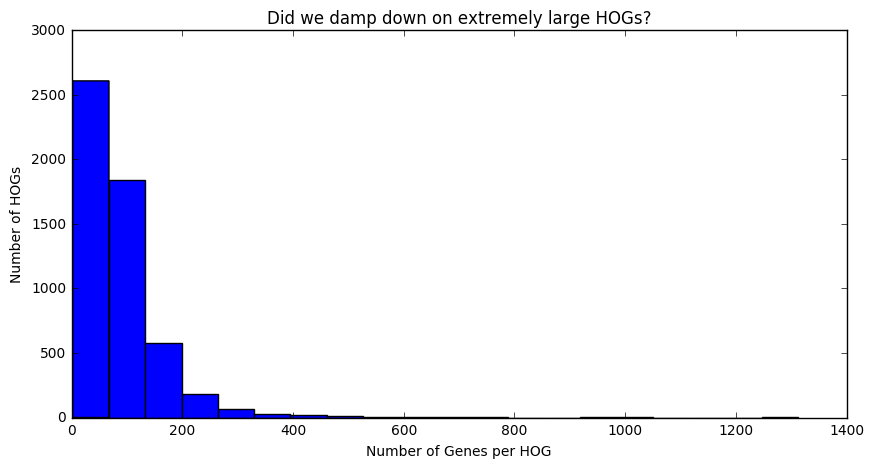

In [23]:
%matplotlib inline
import pandas
lengths = [sum(len(OGs[label]) for label in group) for group in smart_modified_HOGs]
df = pandas.Series(lengths)#, columns=['Family ID', 'Copies'])
bins = 20
f = df.hist(bins=bins, figsize=(10,5), )#dpi=300)
f.grid(False)
f.set_title("Did we damp down on extremely large HOGs?")
f.set_xlabel("Number of Genes per HOG")
f.set_ylabel("Number of HOGs")

** Conclusion: Just filter out HOGs with > 500 genes**

In [25]:
filtered_smart_modified_HOGs = [group for group in smart_modified_HOGs if sum(len(OGs[label]) for label in group) < 500]
pp(len(filtered_smart_modified_HOGs) - len(smart_modified_HOGs))

'-15'

In [ ]:
%matplotlib inline
import pandas
lengths = [sum(len(HOGs[label]) for label in group) for group in modified_HOGs_only]
df = pandas.Series(lengths)#, columns=['Family ID', 'Copies'])
f = df.hist(bins=100, figsize=(10,5), )#dpi=300)
f.grid(False)
f.set_title("Did we damp down on extremely large HOGs?")
f.set_xlabel("Number of Genes per HOG")
f.set_ylabel("Number of HOGs")

## Concat Super HOG fasta into new directory

In [ ]:
from os.path import join, basename, splitext
import os
family_out_dir = r"D:\Genomes\Ash_Gene_Families\capped"
HOGfasta = r"D:\josiah\Documents\Research\Thesis - Genome Symmetry\DNA_Duplications\Ash_Proteome\Results_Jun25\Orthologues_Jul06\Sequences"
os.makedirs(family_out_dir, exist_ok=True)
for family in filtered_smart_modified_HOGs:
    family_name = ('-'.join(family))[:200] + '.fa'
    with open(join(family_out_dir, family_name), 'wb') as concat:  # output file concatenation
        for hog in family:
            with open(join(HOGfasta, hog + '.fa'), 'rb') as hog_file:  # smaller input file
                concat.write(hog_file.read())  # dump the whole file

In [ ]:
pp(len(filtered_smart_modified_HOGs))